### Практическое задание к уроку 4
1) реализовать аналогичного изученному дерева решений, использующего энтропию Шенонна в качестве критерия информативности и сравнить точность(accuracy, balanced_accuracy) достигаемую на используемых синтетических данных с точностью разобранной на уроке реализации
2) реализовать ограничение глубины дерева при построении. Построить на этом же датасете дерево, у которого максимальная глубна листа равна 2.

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn import model_selection

import numpy as np

Реализовал постоение дерева решений в виде класса. По умолчания используется критерий Джинни. Для использования энтропии Шеннона необходимо при создании экзеспляра класса указать параметр method="entropy".  
Расчет метрик accuracy и balanced accuracy также реализованы в классе.

In [66]:
class DecisionTree:
    
    class Node:
    
        def __init__(self, index, t, true_branch, false_branch):
            self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
            self.t = t  # значение порога
            self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
            self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле
        

    class Leaf:

        def __init__(self, data, labels):
            self.data = data
            self.labels = labels
            self.prediction = self.predict()

        def predict(self):
            # подсчет количества объектов разных классов
            classes = {}  # сформируем словарь "класс: количество объектов"
            for label in self.labels:
                if label not in classes:
                    classes[label] = 0
                classes[label] += 1
            #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
            prediction = max(classes, key=classes.get)
            return prediction  
    
    
    def __init__(self, method='gini'):
        self.method = method
        
    def _H(self, labels):
        classes = {}
        for label in labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        
        impurity = 0
        
        if self.method == 'entropy':
            impurity = 0
            for label in classes:
                p = classes[label] / len(labels)
                # Если p равна нулю, то не изменяем impurity, т.к. полагается, что 0*np.log2(0)=0
                if p != 0:
                    impurity -= p * np.log2(p)
        else:
            impurity = 1
            for label in classes:
                p = classes[label] / len(labels)
                impurity -= p ** 2

        return impurity

    def _quality(self, left_labels, right_labels, current_H):

        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

        return current_H - p * self._H(left_labels) - (1 - p) * self._H(right_labels)

    def _split(self, data, labels, index, t):

        left = np.where(data[:, index] <= t)
        right = np.where(data[:, index] > t)

        true_data = data[left]
        false_data = data[right]
        true_labels = labels[left]
        false_labels = labels[right]

        return true_data, false_data, true_labels, false_labels

    def _find_best_split(self, data, labels):

        #  обозначим минимальное количество объектов в узле
        min_leaf = 5

        current_H = self._H(labels)

        best_quality = 0
        best_t = None
        best_index = None

        n_features = data.shape[1]

        for index in range(n_features):
            # будем проверять только уникальные значения признака, исключая повторения
            t_values = np.unique([row[index] for row in data])

            for t in t_values:
                true_data, false_data, true_labels, false_labels = self._split(data, labels, index, t)
                #  пропускаем разбиения, в которых в узле остается менее 5 объектов
                if len(true_data) < min_leaf or len(false_data) < min_leaf:
                    continue

                current_quality = self._quality(true_labels, false_labels, current_H)

                #  выбираем порог, на котором получается максимальный прирост качества
                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index

        return best_quality, best_t, best_index

    def _build_tree(self, data, labels, current_deep):
        
        if current_deep is not None:
            if current_deep == 0:
                return self.Leaf(data, labels)
            current_deep -= 1
        
        quality, t, index = self._find_best_split(data, labels)

        #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
        if quality == 0:
            return self.Leaf(data, labels)

        true_data, false_data, true_labels, false_labels = self._split(data, labels, index, t)

        # Рекурсивно строим два поддерева
        true_branch = self._build_tree(true_data, true_labels, current_deep)
        false_branch = self._build_tree(false_data, false_labels, current_deep)
    
        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        return self.Node(index, t, true_branch, false_branch)
        
    def build(self, data, labels, max_deep=None):
        self.tree = self._build_tree(data, labels, max_deep)

    def _classify_object(self, obj, node):

        #  Останавливаем рекурсию, если достигли листа
        if isinstance(node, self.Leaf):
            answer = node.prediction
            return answer

        if obj[node.index] <= node.t:
            return self._classify_object(obj, node.true_branch)
        else:
            return self._classify_object(obj, node.false_branch)

    def predict(self, data):

        classes = []
        for obj in data:
            prediction = self._classify_object(obj, self.tree)
            classes.append(prediction)
        return classes
    
    def print_tree(self, spacing=""):
        self._print_tree(self.tree, 0, spacing)
    
    def _print_tree(self, node, level, spacing=""):
        # Если лист, то выводим его прогноз
        if isinstance(node, self.Leaf):
            print(f'{spacing}Уровень {level}-> Прогноз: {node.prediction}')
            return

        # Выведем значение индекса и порога на этом узле
        print(spacing + 'Индекс', str(node.index))
        print(spacing + 'Порог', str(node.t))

        # Рекурсионный вызов функции на положительном поддереве
        print (spacing + '--> True:')
        self._print_tree(node.true_branch, level + 1, spacing + "  ")

        # Рекурсионный вызов функции на положительном поддереве
        print (spacing + '--> False:')
        self._print_tree(node.false_branch, level + 1, spacing + "  ")
    
    def accuracy(self, data, labels):
        answers = self.predict(data)
        return self._accuracy_metric(labels, answers)
        
    def _accuracy_metric(self, actual, predicted):
        return np.sum(actual==predicted)/len(actual)
    
    def balanced_accuracy(self, data, labels):
        answers = self.predict(data)
        return self._balanced_accuracy_metric(labels, answers)

    def _balanced_accuracy_metric(self, actual, predicted):
        true_predicted=(actual==predicted).astype(int)
        sensitivity=np.sum(actual*true_predicted)/np.sum(actual==1)
        specificity=np.sum((1-actual)*true_predicted)/np.sum(actual==0)
        return 0.5*(sensitivity+specificity)

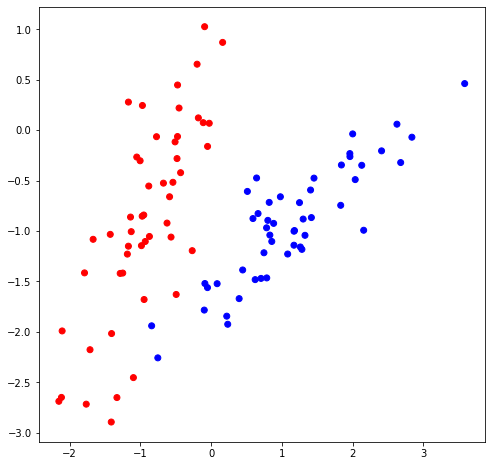

In [30]:
classification_data, classification_labels = datasets.make_classification(n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=5)

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [57]:
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

Дерево, использующее энтропию Шэннона в качестве критерия информативности.

In [67]:
tree_model_e = DecisionTree(method='entropy')

In [74]:
tree_model_e.build(train_data, train_labels, 2)

In [75]:
tree_model_e.print_tree()

Индекс 0
Порог 0.16261402870113306
--> True:
  Индекс 1
  Порог -1.5208896621663803
  --> True:
    Уровень 2-> Прогноз: 0
  --> False:
    Уровень 2-> Прогноз: 0
--> False:
  Уровень 1-> Прогноз: 1


In [76]:
print(f'Train accuracy: {tree_model_e.accuracy(train_data, train_labels)}\nTrain balanced accuracy: {tree_model_e.balanced_accuracy(train_data, train_labels)}')

Train accuracy: 0.9285714285714286
Train balanced accuracy: 0.9285714285714286


In [77]:
print(f'Test accuracy: {tree_model_e.accuracy(test_data, test_labels)}\nTest balanced accuracy: {tree_model_e.balanced_accuracy(test_data, test_labels)}')

Test accuracy: 0.9666666666666667
Test balanced accuracy: 0.9666666666666667


Дерево, использующее критерий Джинни в качестве критерия информативности.

In [78]:
tree_model = DecisionTree()

In [79]:
tree_model.build(train_data, train_labels)

In [80]:
tree_model.print_tree()

Индекс 0
Порог 0.16261402870113306
--> True:
  Индекс 1
  Порог -1.5208896621663803
  --> True:
    Индекс 0
    Порог -0.9478301462477035
    --> True:
      Уровень 3-> Прогноз: 0
    --> False:
      Уровень 3-> Прогноз: 1
  --> False:
    Уровень 2-> Прогноз: 0
--> False:
  Уровень 1-> Прогноз: 1


In [81]:
print(f'Train accuracy: {tree_model.accuracy(train_data, train_labels)}\nTrain balanced accuracy: {tree_model.balanced_accuracy(train_data, train_labels)}')

Train accuracy: 0.9857142857142858
Train balanced accuracy: 0.9857142857142858


In [82]:
print(f'Test accuracy: {tree_model.accuracy(test_data, test_labels)}\nTest balanced accuracy: {tree_model.balanced_accuracy(test_data, test_labels)}')

Test accuracy: 1.0
Test balanced accuracy: 1.0
